In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
from torchvision import transforms
import requests
from torchvision import transforms
import zipfile
from torch.utils.data import DataLoader
import torch
from torch.utils.data import DataLoader, Subset
import requests

# -----------------------------
# Paths and URL
# -----------------------------
url = "http://hadi.cs.virginia.edu:8000/download/train-dataset"
zip_path = "train_dataset.zip"
extract_dir = "train_dataset"

# -----------------------------
# 1. Download the zip file if it doesn't exist
# -----------------------------
if not os.path.exists(zip_path):
    print("Downloading zip file...")
    # Get file size from headers (if provided)
    response = requests.head(url)
    file_size = int(response.headers.get('content-length', 0))

    # Download with progress bar
    response = requests.get(url, stream=True)
    chunk_size = 1024
    with open(zip_path, "wb") as f, tqdm(
        desc=zip_path,
        total=file_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))
else:
    print(f"{zip_path} already exists, skipping download.")

# -----------------------------
# 2. Unzip the file if not already extracted
# -----------------------------
if not os.path.exists(extract_dir):
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Get list of all files in the zip
        all_files = zip_ref.namelist()
        
        # Extract each file with progress bar
        for file in tqdm(all_files, desc="Extracting", unit="file"):
            zip_ref.extract(file, extract_dir)
    print(f"Extracted to {extract_dir}")
else:
    print(f"{extract_dir} already exists, skipping extraction.")

# -----------------------------
# 3. Define transforms
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])

# -----------------------------
# 4. Define PyTorch Dataset
# -----------------------------
class SkinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root folder with subfolders per class.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Gather all class folders
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Gather all image paths and labels
        self.image_paths = []
        self.labels = []
        valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.jfif')

        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            count = 0
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(valid_exts):
                    self.image_paths.append(os.path.join(cls_dir, fname))
                    self.labels.append(self.class_to_idx[cls_name])
                    count += 1
            print(f"Loaded {count} images for class '{cls_name}'")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply transforms if any
        if self.transform:
            image = self.transform(image)

        return image, label


# -----------------------------
# 5. Create Dataset and DataLoader
# -----------------------------

# Create dataset and dataloader
dataset = SkinDataset(root_dir="train_dataset/train_dataset", transform=transform)

# Suppose dataset is your full dataset
dataset_size = len(dataset)
indices = torch.randperm(dataset_size)  # shuffle indices

train_size = int(0.9 * dataset_size)
test_size = dataset_size - train_size

train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=512, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=512, shuffle=True)

print(f"train_dataset size: {len(train_dataset)}")
print(f"test_dataset size: {len(test_dataset)}")




train_dataset.zip already exists, skipping download.
train_dataset already exists, skipping extraction.
Loaded 751 images for class '1. Eczema'
Loaded 931 images for class '10. Warts Molluscum and other Viral Infections'
Loaded 938 images for class '2. Melanoma'
Loaded 563 images for class '3. Atopic Dermatitis'
Loaded 993 images for class '4. Basal Cell Carcinoma'
Loaded 2381 images for class '5. Melanocytic Nevi'
Loaded 931 images for class '6. Benign Keratosis-like Lesions'
Loaded 921 images for class '7. Psoriasis pictures Lichen Planus and related diseases'
Loaded 828 images for class '8. Seborrheic Keratoses and other Benign Tumors'
Loaded 763 images for class '9. Tinea Ringworm Candidiasis and other Fungal Infections'
train_dataset size: 9000
test_dataset size: 1000


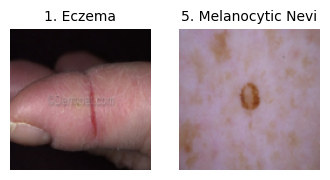

In [24]:
import matplotlib.pyplot as plt

# Get a batch of test images
dataiter = iter(dataloader_test)
images, labels = next(dataiter)

images = images[-2:]
labels = labels[-2:]

# Move to CPU for plotting
images = images.cpu()
labels = labels.cpu()

# Plot images with labels
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for i in range(2):
    img = images[i].permute(1, 2, 0).numpy()  # convert from (C,H,W) to (H,W,C)
    axes[i].imshow(img)
    axes[i].set_title(f"{dataset.classes[labels[i]]}", fontsize=10)
    axes[i].axis("off")

plt.show()


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from collections import Counter

# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Match number of output classes
num_classes = len(dataset.classes)
print(f"Detected {num_classes} classes")
# -----------------------------


# -----------------------------
# 6. Build model
# -----------------------------
class LinearModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(3 * 120 * 120, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten image
        return self.fc(x)

model = LinearModel(num_classes).to(device)
# -----------------------------
# Loss and Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

num_epochs = 5

for epoch in range(num_epochs):
    # -----------------------------
    # Training
    # -----------------------------
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for images, labels in dataloader_train:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Collect predictions for training metrics
        preds = torch.argmax(outputs, dim=1)
        train_preds.append(preds.cpu())
        train_labels.append(labels.cpu())

    epoch_loss = running_loss / len(dataloader_train.dataset)
    train_preds = torch.cat(train_preds)
    train_labels = torch.cat(train_labels)
    train_acc = accuracy_score(train_labels.numpy(), train_preds.numpy())
    train_f1 = f1_score(train_labels.numpy(), train_preds.numpy(), average='macro')
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}")

    # -----------------------------
    # Evaluation on test set
    # -----------------------------
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for images, labels in dataloader_test:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            test_preds.append(preds.cpu())
            test_labels.append(labels.cpu())

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)
    test_acc = accuracy_score(test_labels.numpy(), test_preds.numpy())
    test_f1 = f1_score(test_labels.numpy(), test_preds.numpy(), average='macro')
    print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")


# -----------------------------
# Save Model
# -----------------------------
model.eval()
save_name = "LinearModel.pth"

# Script and save the model
scripted_model = torch.jit.script(model)
scripted_model.save(save_name)
print(f"Model saved as {save_name}")

# Get file size in bytes and convert to MB
size_bytes = os.path.getsize(save_name)
size_mb = size_bytes / (1024 * 1024)
print(f"Model size: {size_mb:.2f} MB")


Using device: cuda
Detected 10 classes
Epoch 1/5, Train Loss: 10.2952, Train Accuracy: 0.1489, Train F1: 0.1071
Epoch 1/5, Test Accuracy: 0.1780, Test F1: 0.0839
Epoch 2/5, Train Loss: 4.5386, Train Accuracy: 0.2111, Train F1: 0.1597
Epoch 2/5, Test Accuracy: 0.2830, Test F1: 0.1184
Epoch 3/5, Train Loss: 2.5195, Train Accuracy: 0.2959, Train F1: 0.2085
Epoch 3/5, Test Accuracy: 0.2840, Test F1: 0.1723
Epoch 4/5, Train Loss: 1.9519, Train Accuracy: 0.3352, Train F1: 0.2470
Epoch 4/5, Test Accuracy: 0.3210, Test F1: 0.2033
Epoch 5/5, Train Loss: 1.8096, Train Accuracy: 0.3499, Train F1: 0.2539
Epoch 5/5, Test Accuracy: 0.3280, Test F1: 0.2122
Model saved as LinearModel.pth
Model size: 1.65 MB


In [26]:
# -------------------------
# 7. Submit to server
# -------------------------
def submit_model(token: str, model_path: str, server_url="http://hadi.cs.virginia.edu:8000"):
    with open(model_path, "rb") as f:
        files = {"file": f}
        data = {"token": token}
        response = requests.post(f"{server_url}/submit", data=data, files=files)
        resp_json = response.json()
        if "message" in resp_json:
            print(f"✅ {resp_json['message']}")
        else:
            print(f"❌ Submission failed: {resp_json.get('error')}")


# Replace with your team token
my_token = "Your_token_here"
file_name = "model.pth"
submit_model(my_token, file_name)

✅ Submission received for team 'LinearModel'. This is attempt #1, status pending, evaluation pending.


In [28]:
# -------------------------
# 8. Check status
# -------------------------
import requests
import time

def check_submission_status(my_token, max_retries=3):
    url = f"http://hadi.cs.virginia.edu:8000/submission-status/{my_token}"

    for attempt in range(max_retries):
        response = requests.get(url)

        if response.status_code == 200:
            attempts = response.json()
            for a in attempts:
                # Format score and model_size if they exist, otherwise show 'pending'
                score = f"{a['score']:.4f}" if isinstance(a['score'], (float, int)) else "None"
                model_size = f"{a['model_size']:.4f}" if isinstance(a['model_size'], (float, int)) else "None"

                print(f"Attempt {a['attempt']}: Score={score}, Model size={model_size}, "
                      f"Submitted at={a['submitted_at']}, Status={a['status']}")

            if attempts and attempts[-1]['status'].lower() == "broken file":
                print("⚠️ Your model on the server is broken!")
            return  # success, exit function

        elif response.status_code == 429:
            # Server says rate limit exceeded
            try:
                error_json = response.json()
                wait_seconds = int(error_json.get("error", "").split()[-2])
            except Exception:
                wait_seconds = 15  # default fallback
            print(f"⏳ Rate limited. Waiting {wait_seconds} seconds before retry...")
            time.sleep(wait_seconds + 1)  # wait a bit longer to be safe

        else:
            print(f"❌ Error {response.status_code}: {response.text}")
            return

    print("⚠️ Max retries reached. Try again later.")


# Example usage:
check_submission_status(my_token)



Attempt 1: Score=0.2058, Model size=1.6516, Submitted at=Sep 24, 2025 11:22:24 PM, Status=successful
